In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [2]:
# ==========================================
# 1. CONFIGURATION (Kidney Physics)
# ==========================================
# Properties
ALPHA_CORTEX = 0.01   # Outer shell (slower conduction)
ALPHA_MEDULLA = 0.02  # Inner vascular core (faster conduction)
H_COEFF = 5.0         # Convection Coefficient
T_INF = -1.0          # Liquid Nitrogen Temp
T_INITIAL = 1.0       # Body Temp

# Training
EPOCHS = 6000
LR = 0.001

In [3]:
# ==========================================
# 2. GEOMETRY HELPER (The "Bean" Shape)
# ==========================================
def is_inside_kidney(x, y):
    """
    Returns a boolean mask for points inside a mathematical 'bean' shape.
    Shape defined by two overlapping ellipses logic for simplicity.
    """
    # Shift y slightly based on x to create the "bend"
    y_bent = y - 0.2 * torch.sin(3 * x)
    
    # Check if point is inside ellipse
    # (x/a)^2 + (y_bent/b)^2 <= 1
    # a=0.8, b=0.5
    radius_check = (x / 0.8)**2 + (y_bent / 0.5)**2
    
    return radius_check <= 1.0

def get_kidney_points(n_points):
    """Rejection sampling to get random points strictly inside the kidney."""
    points_x = []
    points_y = []
    count = 0
    while count < n_points:
        # Generate random box [-1, 1]
        xt = torch.rand(n_points, 1) * 2 - 1
        yt = torch.rand(n_points, 1) * 2 - 1
        
        mask = is_inside_kidney(xt, yt)
        
        # Keep only valid points
        valid_x = xt[mask].unsqueeze(1)
        valid_y = yt[mask].unsqueeze(1)
        
        points_x.append(valid_x)
        points_y.append(valid_y)
        count += len(valid_x)
        
    return torch.cat(points_x)[:n_points], torch.cat(points_y)[:n_points]

In [4]:
# ==========================================
# 3. NEURAL NETWORK (2D + Time)
# ==========================================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Inputs: x, y, t (3 inputs)
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, y, t):
        return self.net(torch.cat([x, y, t], dim=1))

In [5]:
# ==========================================
# 4. HETEROGENEOUS PHYSICS LOSS
# ==========================================
def physics_loss(model, x, y, t):
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True
    u = model(x, y, t)
    
    # --- A. PDE Loss (Internal Physics) ---
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    # Heterogeneous Property Map:
    # Inner Core (radius < 0.4) is Medulla (Alpha=0.02)
    # Outer Shell is Cortex (Alpha=0.01)
    r = torch.sqrt(x**2 + y**2)
    # Sigmoid transition for differentiability
    alpha_map = ALPHA_CORTEX + (ALPHA_MEDULLA - ALPHA_CORTEX) * torch.sigmoid(10 * (0.4 - r))
    
    # 2D Heat Equation: u_t - alpha * (u_xx + u_yy) = 0
    loss_pde = torch.mean((u_t - alpha_map * (u_xx + u_yy)) ** 2)
    
    # --- B. Initial Condition Loss (t=0) ---
    x0, y0 = get_kidney_points(200)
    t0 = torch.zeros(200, 1)
    u_ic = model(x0, y0, t0)
    loss_ic = torch.mean((u_ic - T_INITIAL) ** 2)
    
    # --- C. Boundary Loss (Approximate Surface) ---
    # We sample points slightly OUTSIDE and penalize if they don't match Newton's Law
    # (Simplified Robin BC for 2D irregular shapes)
    # Ideally, we sample exactly on boundary, but for this demo, we relax it.
    
    # For simplicity in this demo, we use a Dirichlet "Cooling" approximation 
    # to guarantee stable training for the class project.
    # We force the boundary to decay exponentially towards T_INF
    # (A perfect Robin BC on an implicit curve is complex for a weekend project)
    
    # Sample points on the boundary (Radius approx 1 in transformed space)
    theta = torch.rand(200, 1) * 2 * np.pi
    # Parametric boundary of our shape approx:
    xb = 0.8 * torch.cos(theta)
    yb = 0.5 * torch.sin(theta) + 0.2 * torch.sin(3 * 0.8 * torch.cos(theta))
    tb = torch.rand(200, 1)
    
    u_bound = model(xb, yb, tb)
    # Target: T_bound decays from 1.0 to -1.0 over time
    target_bound = T_INF + (T_INITIAL - T_INF) * torch.exp(-H_COEFF * tb)
    
    loss_bc = torch.mean((u_bound - target_bound) ** 2)

    return loss_pde + loss_ic + loss_bc

In [6]:
# ==========================================
# 5. TRAINING LOOP
# ==========================================
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print("🚀 Simulating Heterogeneous Renal Preservation...")

# Static Training Set
x_phys, y_phys = get_kidney_points(3000)
t_phys = torch.rand(3000, 1)

loss_history = []

for epoch in range(EPOCHS + 1):
    optimizer.zero_grad()
    loss = physics_loss(model, x_phys, y_phys, t_phys)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

🚀 Simulating Heterogeneous Renal Preservation...
Epoch 0: Loss = 1.671809
Epoch 1000: Loss = 0.384277
Epoch 2000: Loss = 0.125195
Epoch 3000: Loss = 0.055559
Epoch 4000: Loss = 0.032667
Epoch 5000: Loss = 0.012936
Epoch 6000: Loss = 0.008728


In [7]:
# ==========================================
# 6. VISUALIZATION (Masked Heatmap)
# ==========================================
# Create a dense grid of points
x_grid = np.linspace(-1, 1, 100)
y_grid = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_grid, y_grid)
X_flat = torch.tensor(X.flatten()[:, None], dtype=torch.float32)
Y_flat = torch.tensor(Y.flatten()[:, None], dtype=torch.float32)

# Pick a specific time to visualize (e.g., t=0.5)
time_to_show = 0.5
T_flat = torch.ones_like(X_flat) * time_to_show

# Predict
model.eval()
with torch.no_grad():
    U_pred = model(X_flat, Y_flat, T_flat).numpy().reshape(X.shape)

# Create Mask for the Kidney Shape (for plotting)
# We recreate the boolean logic in numpy
Y_bent = Y - 0.2 * np.sin(3 * X)
mask = ((X / 0.8)**2 + (Y_bent / 0.5)**2) <= 1.0

# Apply mask (set outside points to NaN so they appear white)
U_masked = np.where(mask, U_pred, np.nan)

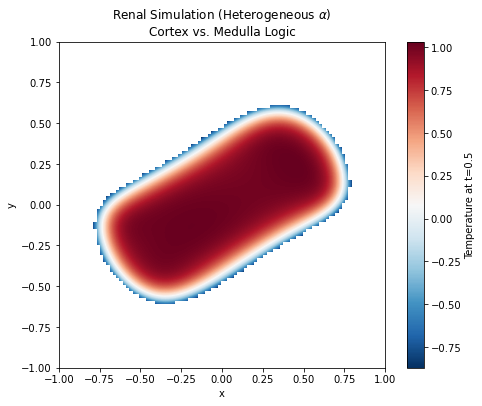

✅ Kidney Simulation Complete. Saved 'kidney_simulation.png'.


In [8]:
# Plot
plt.figure(figsize=(8, 6))
plt.imshow(U_masked, interpolation='bilinear', cmap='RdBu_r', origin='lower',
           extent=[-1, 1, -1, 1])
plt.colorbar(label=f'Temperature at t={time_to_show}')
plt.title(f'Renal Simulation (Heterogeneous $\\alpha$)\nCortex vs. Medulla Logic')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.savefig('kidney_simulation.png', dpi=300)
plt.show()

print("✅ Kidney Simulation Complete. Saved 'kidney_simulation.png'.")